In [40]:
import numpy as np
import emcee
import corner
import matplotlib.pyplot as plt
import random
from scipy.optimize import curve_fit

# Plot settings
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
%matplotlib inline
%config InlineBackend.figure_format='retina'

#################################################-----------------------###########################################

M_D = 3.42752e+01
a = 3
b = 0.05 * a

R_max = 30  # kpc
z_max = 5


def rho_D(R, z, a=a, b=b):
    ''' Densità volumica di Miyamoto-Nagai  '''
    sqrt_zb = np.sqrt(z**2 + b**2)
    numerator = b**2 * M_D * (a * R**2 + (a + 3 * sqrt_zb) * (a + sqrt_zb)**2)
    denominator = 4 * np.pi * (R**2 + (a + sqrt_zb)**2)**(5/2) * (z**2 + b**2)**(3/2)
    return numerator / denominator


def log_prior(params):
    # Uniform priors within the specified ranges
    R, z, phi = params
    if (0 <= R <= R_max) and (-z_max <= z <= z_max) and (0 <= phi <= 2*np.pi):
        return 0.0  # uniform prior
    return -np.inf  # log probability of zero if outside ranges

def log_likelihood(params):
    R, z, phi = params
    return np.log(rho_D(R, z)*2*np.pi*R)

def log_posterior(params):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params)



In [43]:
# MCMC Setup
ndim = 3  # R, z, phi
nwalkers = 30  # Number of MCMC walkers
nsteps = 80000  # Number of steps

# Initial guess - randomly distributed within priors
initial_guess = np.random.uniform(
    low=[0, -5, 0],
    high=[30, 5, 2*np.pi],
    size=(nwalkers, ndim)
)

# Run MCMC
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior)
sampler.run_mcmc(initial_guess, nsteps, progress=True)


100%|███████████████████████████████████████████████████████████████████████████| 80000/80000 [00:54<00:00, 1479.77it/s]


State([[ 4.14695839e+00 -3.83718083e-02  1.28209034e+00]
 [ 1.17872615e+01  1.39729209e-01  9.25430084e-01]
 [ 2.52066499e+00 -1.11445544e-01  3.36236041e-01]
 [ 2.04920598e+00  2.93130897e-02  5.73964921e+00]
 [ 1.26578372e+00  1.78307590e-02  3.77162460e+00]
 [ 1.75547869e+00 -8.24103441e-02  3.89429968e-01]
 [ 1.11350764e+01 -1.39484886e-01  3.85254978e+00]
 [ 7.01393074e+00  9.51139123e-02  5.08442383e+00]
 [ 2.26290754e+01  1.28140105e-01  4.60479215e-01]
 [ 5.49495600e+00 -2.53392497e-01  3.92928293e+00]
 [ 2.46024541e-01  1.04352045e-03  4.35516867e+00]
 [ 4.68096093e+00  2.07807167e-01  5.83213477e+00]
 [ 8.78459287e+00  3.11422823e-02  2.04875994e+00]
 [ 1.93845490e+01  2.13974398e-01  3.35478090e+00]
 [ 5.28476259e+00 -1.45921937e-01  6.00399231e+00]
 [ 2.36778543e+00 -1.97679344e-01  4.68435595e+00]
 [ 3.56614532e+00 -1.40502857e-01  2.14205524e+00]
 [ 1.31740002e+00  1.38742806e-01  2.55517357e+00]
 [ 9.42285785e-01 -4.54579971e-02  6.16660190e+00]
 [ 1.18743724e+01 -3.2712

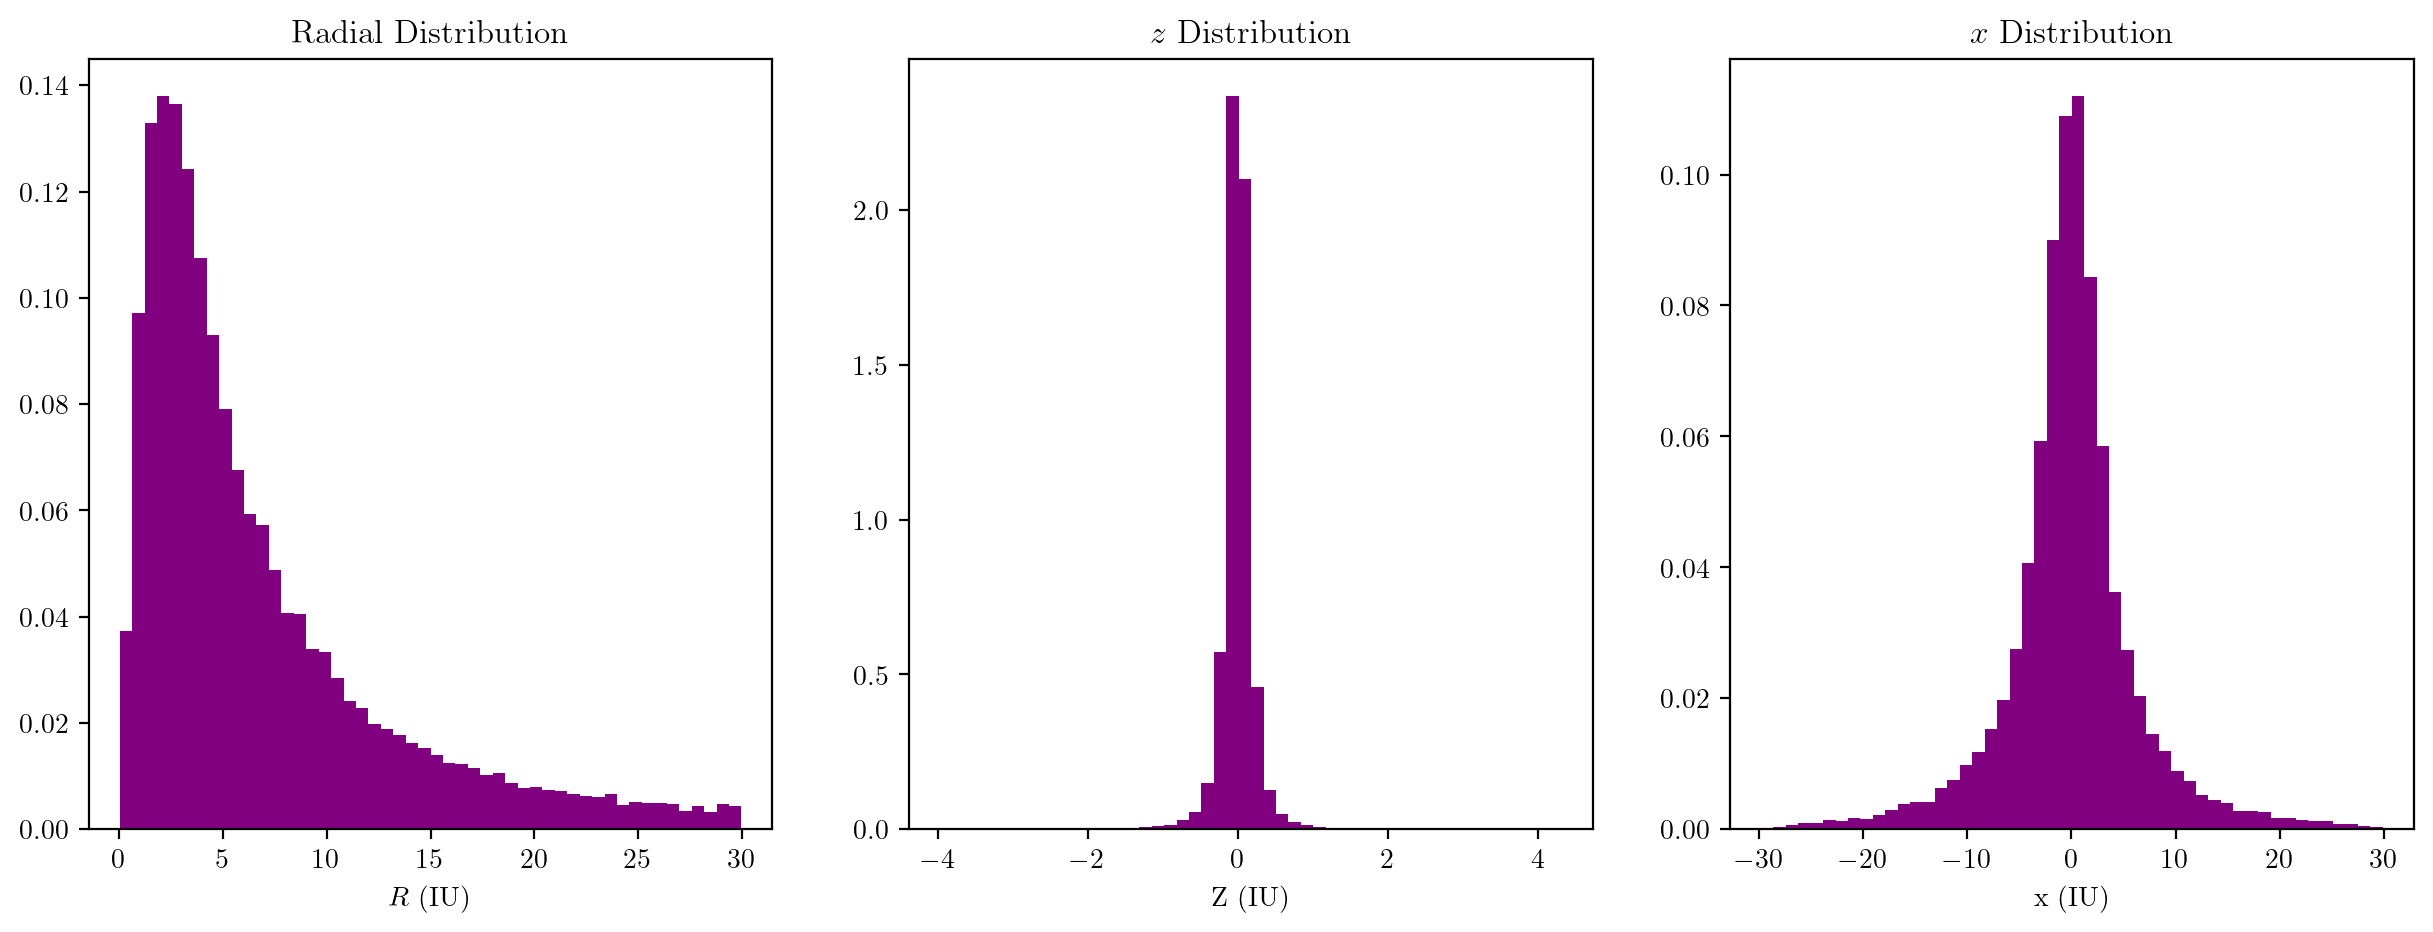

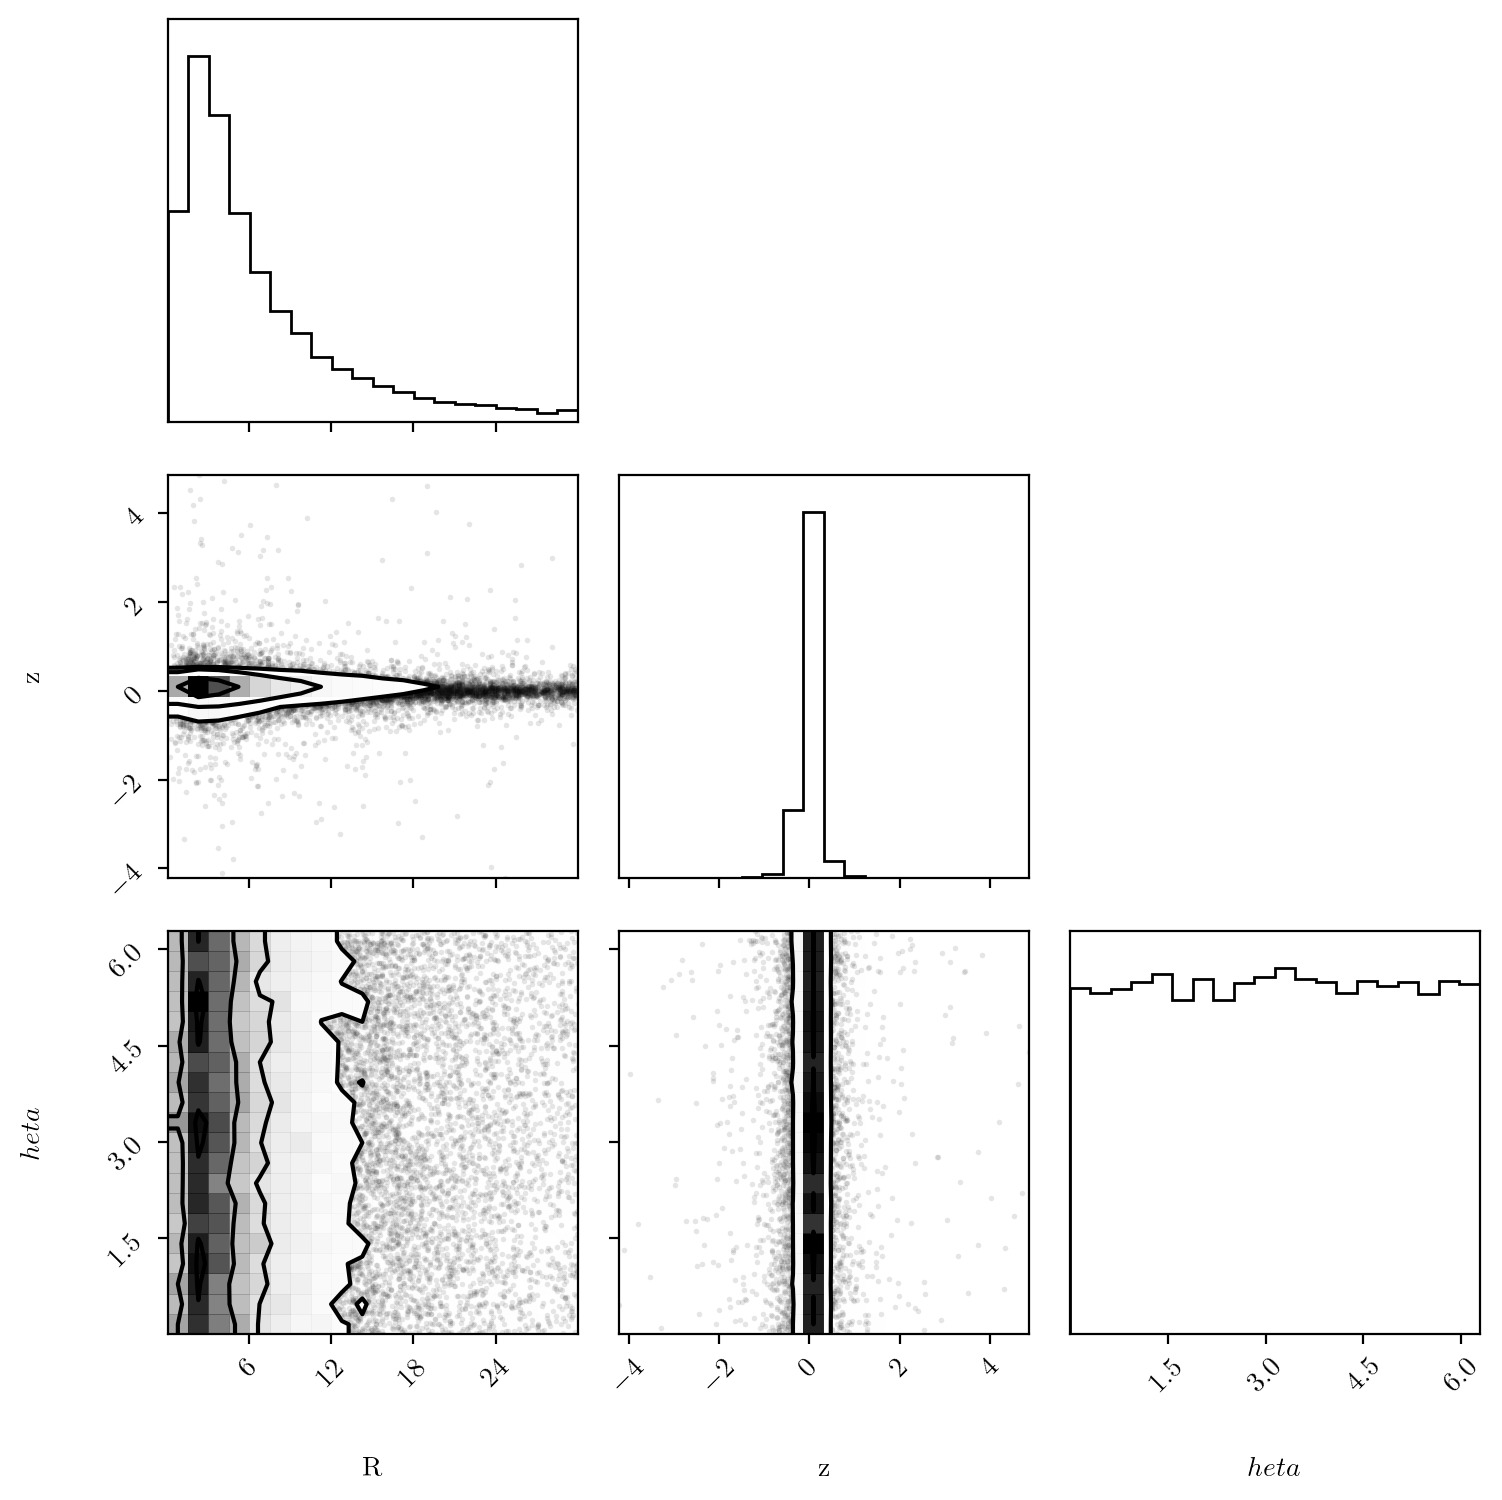

In [44]:
# Discard burn-in and flatten chains
Npart = 20000

#flat_samples = sampler.get_chain(discard=3000, flat=True)
#unique_samples = np.unique(flat_samples, axis=0)
#flat_samples_subset = unique_samples[np.random.choice(unique_samples.shape[0], Npart , replace=False)]
#s[np.random.choice(flat_samples.shape[0], 30000, replace=False)]

# Calcolo del tempo di autocorrelazione
tau = sampler.get_autocorr_time()

# Sottocampionamento della catena
flat_samples = sampler.get_chain(discard=3000, flat=True, thin=int(np.max(tau)))

# Assicurati che il numero di campioni sia sufficiente
if flat_samples.shape[0] < Npart:
    raise ValueError("Numero di campioni indipendenti insufficiente rispetto a Npart richiesto!")

unique_samples = np.unique(flat_samples, axis=0)
flat_samples_subset = unique_samples[np.random.choice(unique_samples.shape[0], Npart , replace=False)]

# Estrai un sottoinsieme casuale di campioni indipendenti
#flat_samples_subset = flat_samples[np.random.choice(flat_samples.shape[0], Npart, replace=False)]

# Converti in coordinate cartesiane
R_samples = flat_samples_subset[:, 0]
z_samples = flat_samples_subset[:, 1]
phi_samples = flat_samples_subset[:, 2]


# Convert to Cartesian coordinates
R_samples = flat_samples_subset[:, 0]
z_samples = flat_samples_subset[:, 1]
phi_samples = flat_samples_subset[:, 2]

x_particles = R_samples * np.cos(phi_samples)
y_particles = R_samples * np.sin(phi_samples)
z_particles = z_samples

plt.figure(figsize=(15,5))

# Radial distribution
plt.subplot(131)
R = np.sqrt(x_particles**2 + y_particles**2)
plt.hist(R, bins=50, density=True, color='purple')
plt.title('Radial Distribution')
plt.xlabel('$R$ (IU)')

# Z distribution
plt.subplot(132)
plt.hist(z_particles, bins=50, density=True, color='purple')
plt.title('$z$ Distribution')
plt.xlabel('Z (IU)')

plt.subplot(133)
plt.hist(x_particles, bins=50, density=True,  color='purple')
plt.title('$x$ Distribution')
plt.xlabel('x (IU)')

plt.subplot(133)
corner.corner(flat_samples, labels=['R', 'z', '$\theta$'])

plt.tight_layout()
plt.show()

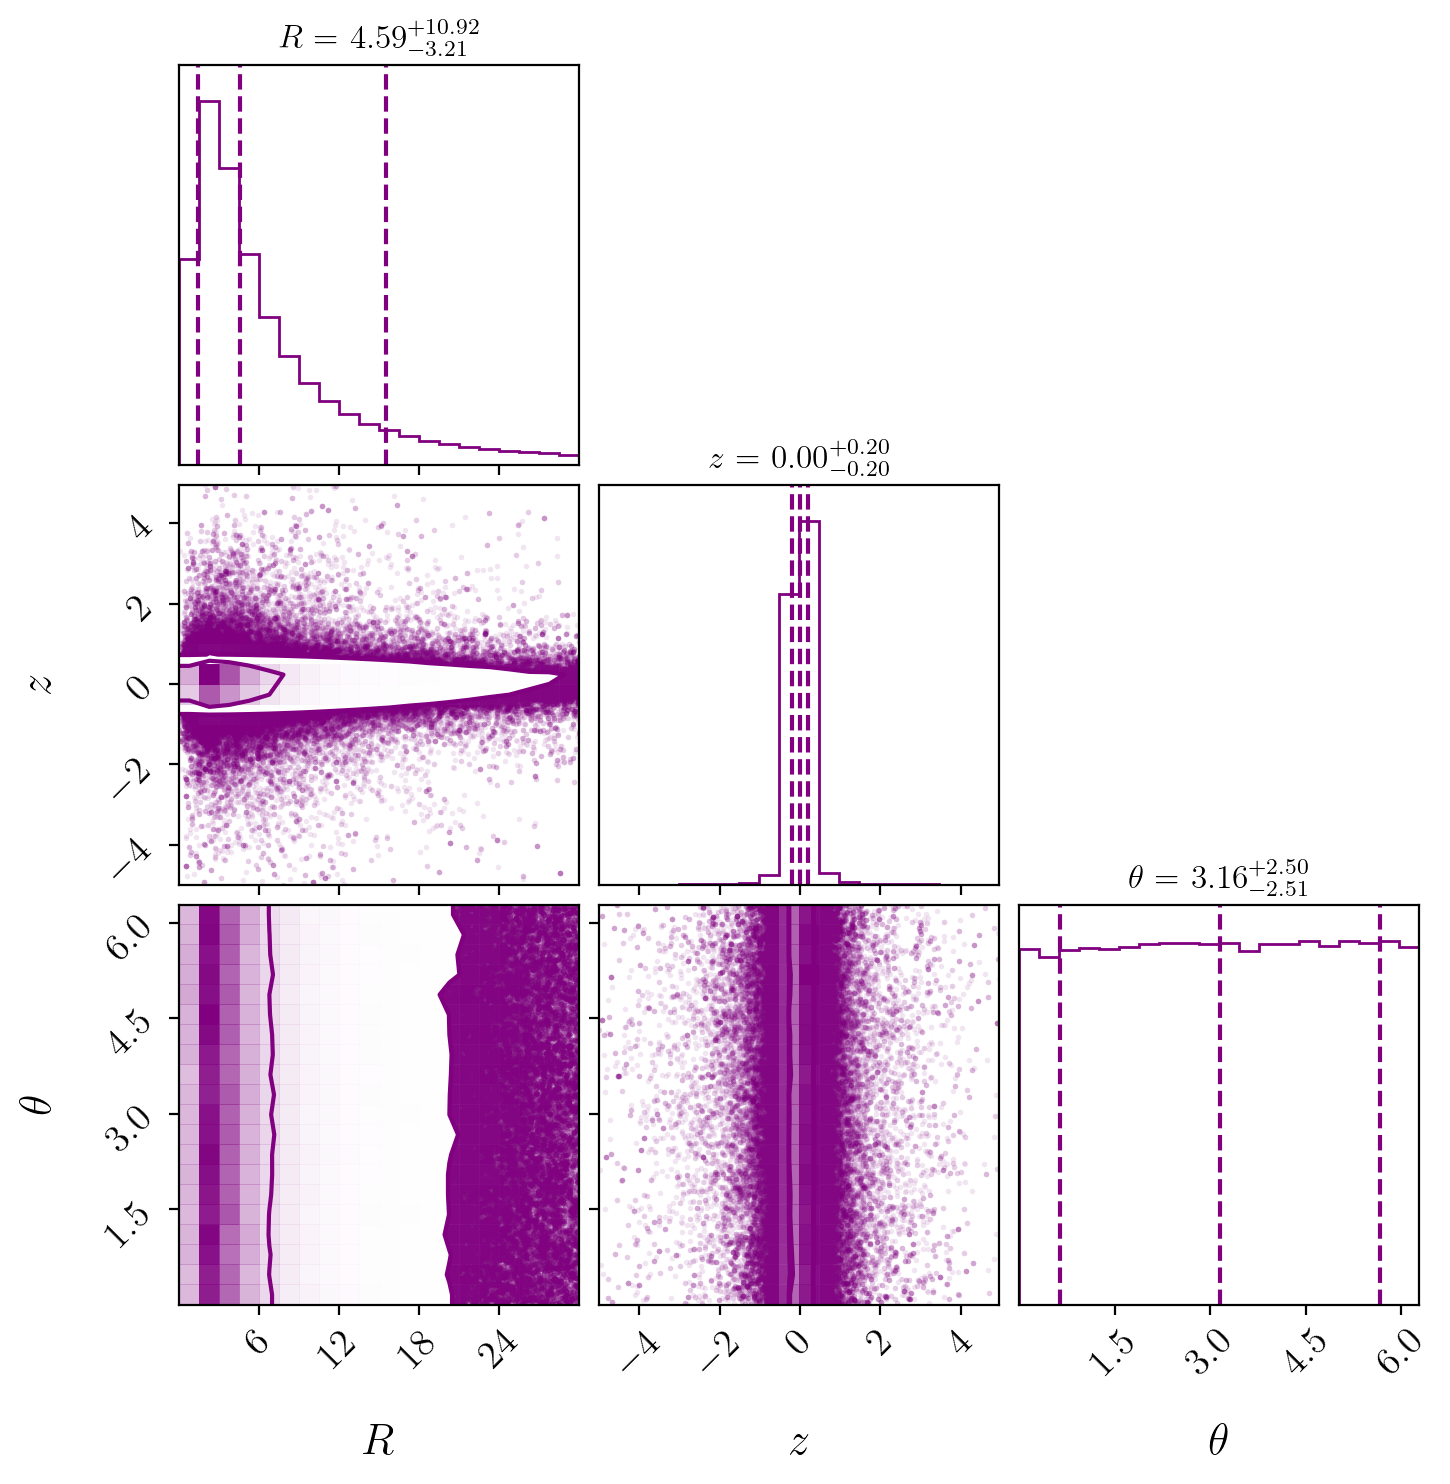

In [14]:
fig = corner.corner(
    flat_samples,
    labels=['$R$', '$z$', r'$\theta$'],
    quantiles=[0.10, 0.5, 0.90],
    show_titles=True,
    title_fmt=".2f",
    levels=(0.68, 0.95),
    plot_density=True,
    color='purple'
)
for ax in fig.axes:
    ax.tick_params(axis='both', labelsize=14)  # Set the tick label font size
    ax.set_xlabel(ax.get_xlabel(), fontsize=16)  # Set x-axis label font size
    ax.set_ylabel(ax.get_ylabel(), fontsize=16)  # Set y-axis label font size
#plt.savefig('corner_mcmc.png')
plt.show()

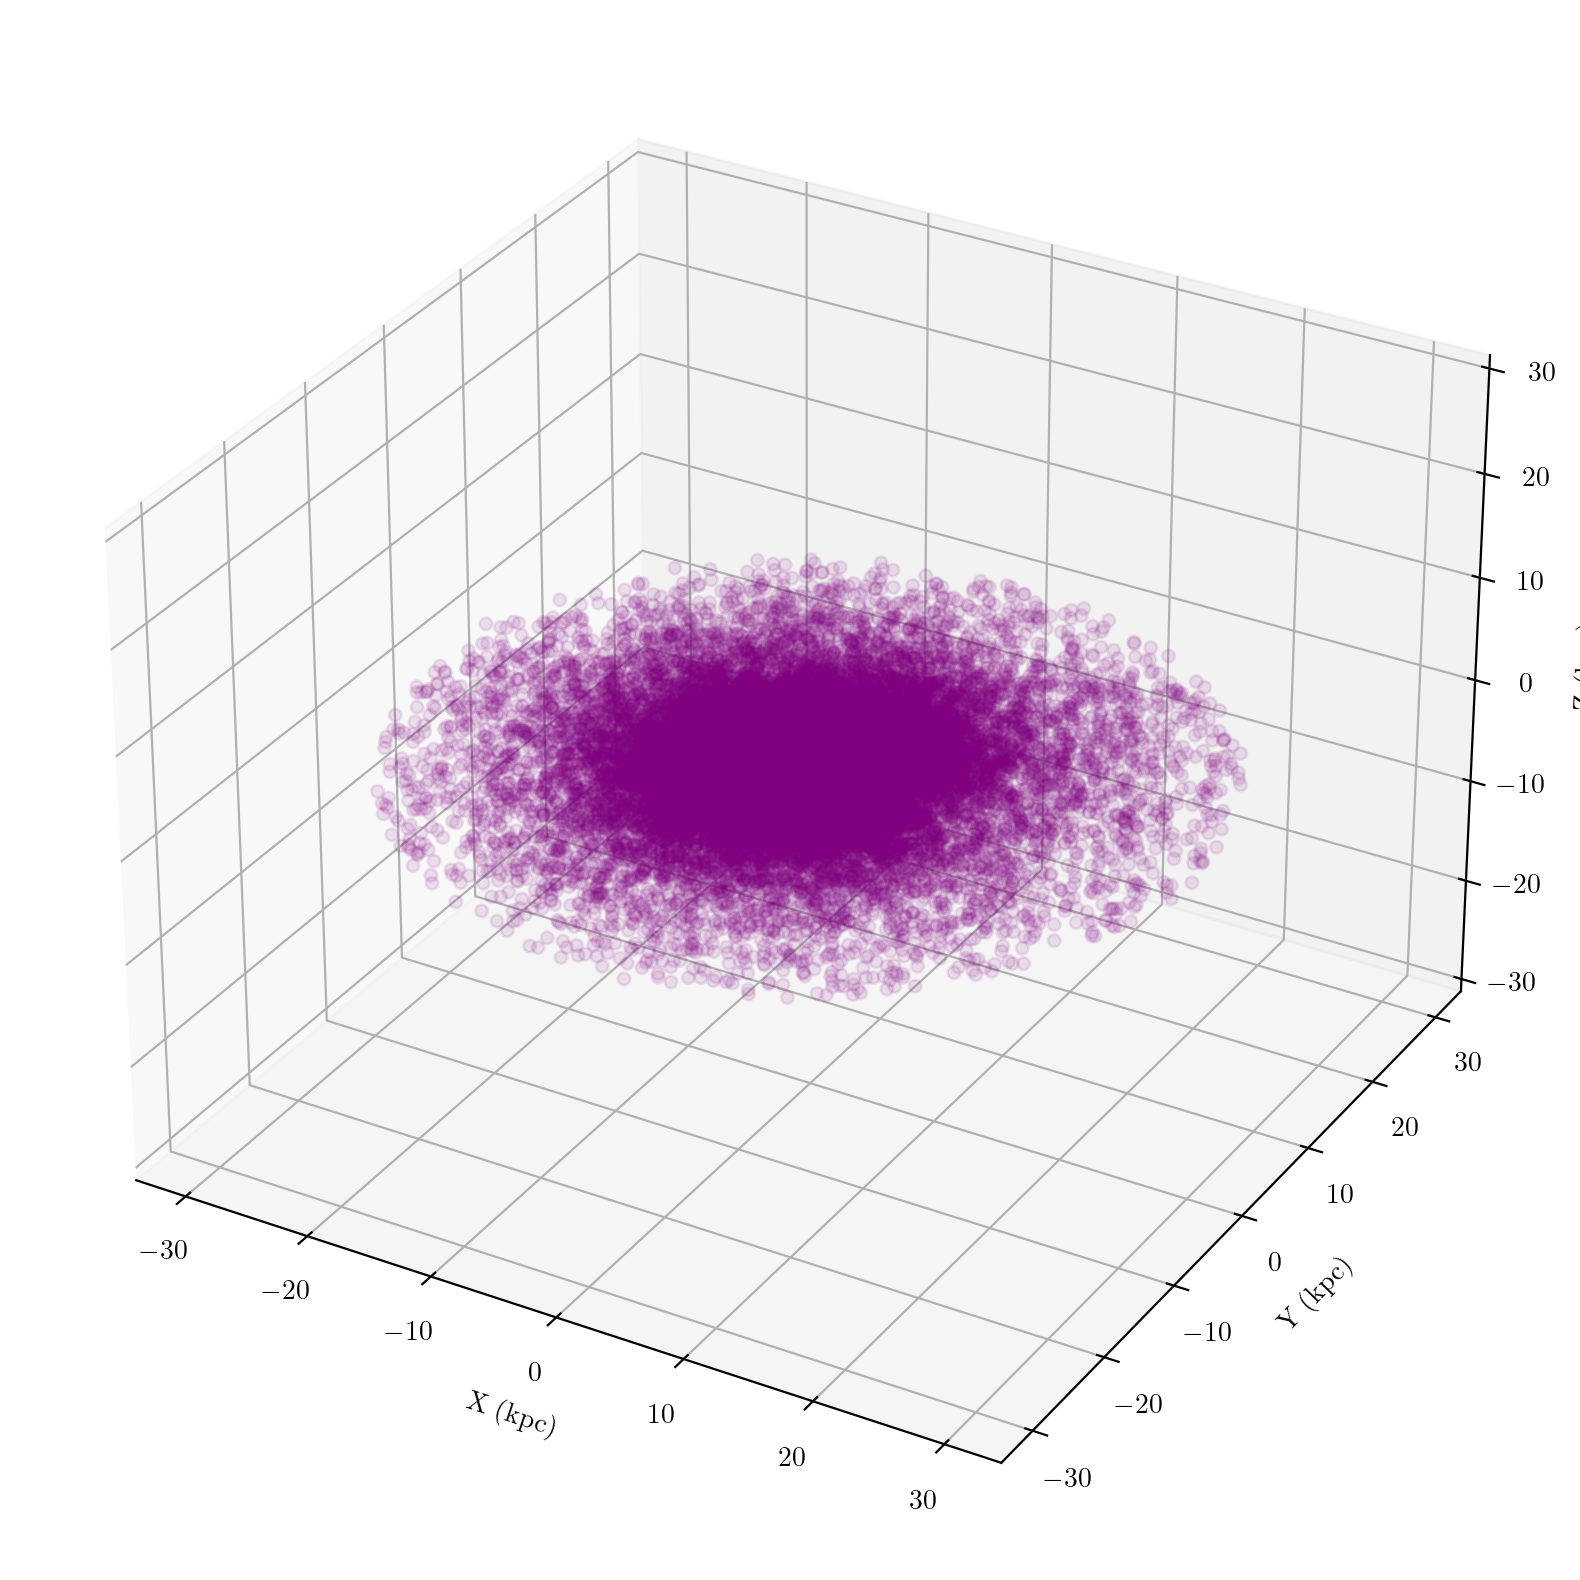

In [15]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_particles, y_particles, z_particles, alpha=0.1, color='purple')
ax.set_xlabel('X (kpc)')
ax.set_ylabel('Y (kpc)')
ax.set_zlabel('Z (kpc)')
#x.set_xlim(-30,30)
#ax.set_ylim(-30,30)
ax.set_zlim(-30,30)
plt.show()

In [5]:
coordinates = np.array([x_particles, y_particles, z_particles, R_samples, phi_samples])
np.save("coord_MCMC_20k.npy", coordinates)
print("File salvato come 'coord_MCM.npy'.")

File salvato come 'coord_MCM.npy'.


In [39]:
loaded_coordinates = np.load("coord_MCMC_20k.npy")
x_particles, y_particles, z_particles, R_particles, phi_particles = loaded_coordinates

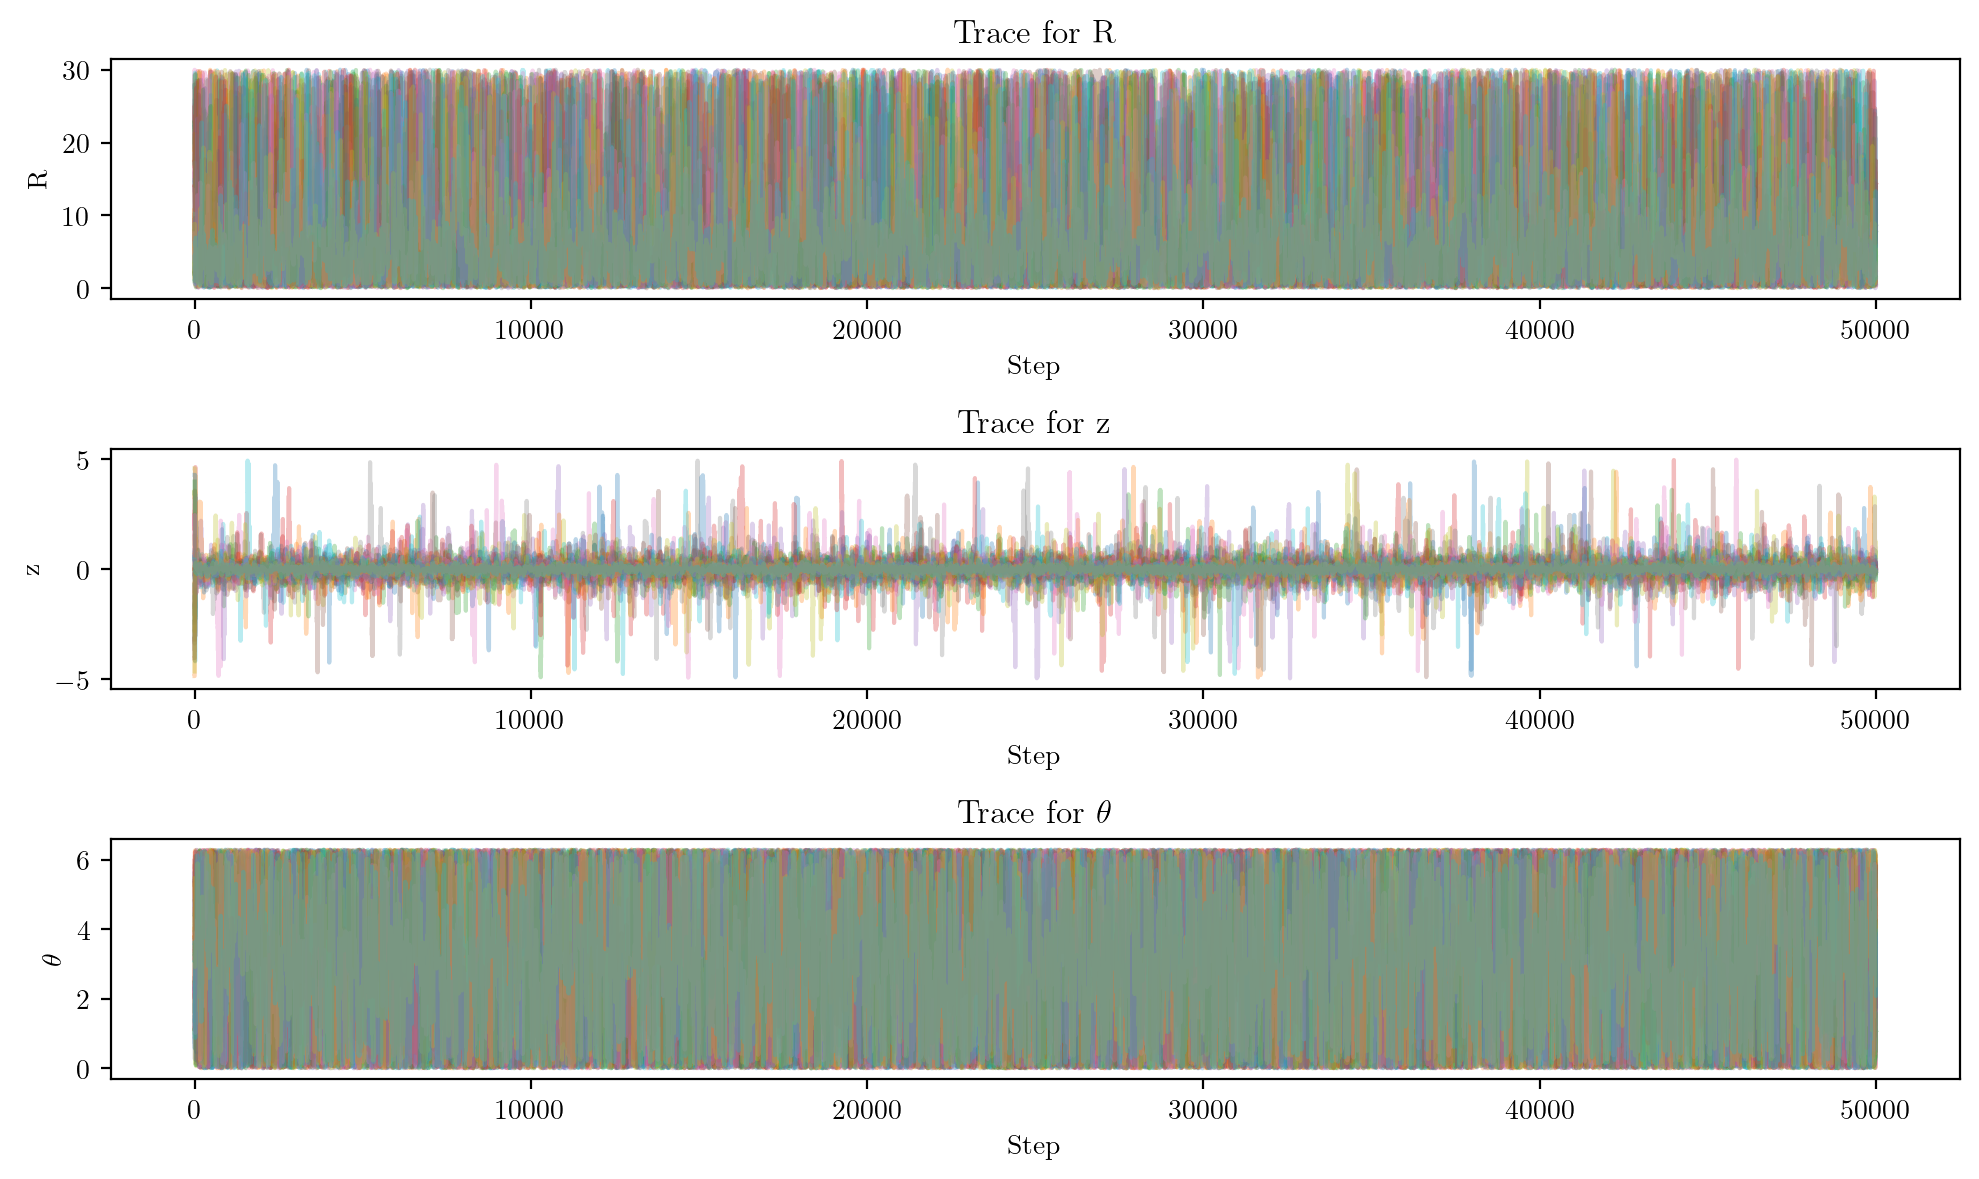

In [26]:
# Plot the traces (walker paths) for each parameter
plt.figure(figsize=(10, 6))

# Get the full chain before flattening
samples = sampler.get_chain()

# Plot traces for R, z, and phi
parameter_names = ['R', 'z', r'$\theta$']
for i in range(3):
    plt.subplot(3, 1, i+1)
    for j in range(nwalkers):
        plt.plot(samples[:, j, i], alpha=0.3)
    plt.title(f'Trace for {parameter_names[i]}')
    plt.xlabel('Step')
    plt.ylabel(parameter_names[i])

plt.tight_layout()
plt.show()

---
# Surface density - check sperimental/theoretical

In [48]:
#M_D = 34.275152
def Sigma(R_values, M_D, z_max = 5):
    Sigma_values = np.zeros_like(R_values)

    # Calcola l'integrale per ciascun valore di R
    for i, R in enumerate(R_values):
        Sigma_values[i] = 2 * np.trapz([rho_D(R, z) for z in np.linspace(0, z_max, 100)], dx=float(z_max/100))

    return Sigma_values

In [53]:
def surface_density_R(masses, positions, num_bins):
    x, y = positions[:, 0], positions[:, 1]
    R = np.sqrt(x**2 + y**2)
    bins = np.geomspace(R.min(), R.max(), num_bins)
    
    # Calculate mass and count in bins
    mass_in_bins, bin_edges = np.histogram(R, bins=bins, weights=masses)
    particle_counts, _ = np.histogram(R, bins=bins)
    
    # Calculate bin areas
    bin_areas = np.pi * (bin_edges[1:]**2 - bin_edges[:-1]**2)
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    
    # Surface density with error estimation
    surface_density = mass_in_bins / bin_areas
    
    # Error estimation using Poisson statistics and error propagation
    # Relative error based on number of particles in each bin
    surface_density_errors = np.where(
        particle_counts > 0, 
        surface_density * np.sqrt(1 / particle_counts),  # Fractional error
        surface_density  # For bins with zero particles, use full value as error
    )
    
    return bin_centers, surface_density, surface_density_errors, bin_edges

In [50]:
m = np.ones(Npart) * M_D / Npart
positions_3d = np.stack([x_particles, y_particles, z_particles]).T

x, y = positions_3d[:, 0], positions_3d[:, 1]
R = np.sqrt(x**2 + y**2)

R_grid = np.linspace(0.3, 30, 100)

(0.0, 0.7)

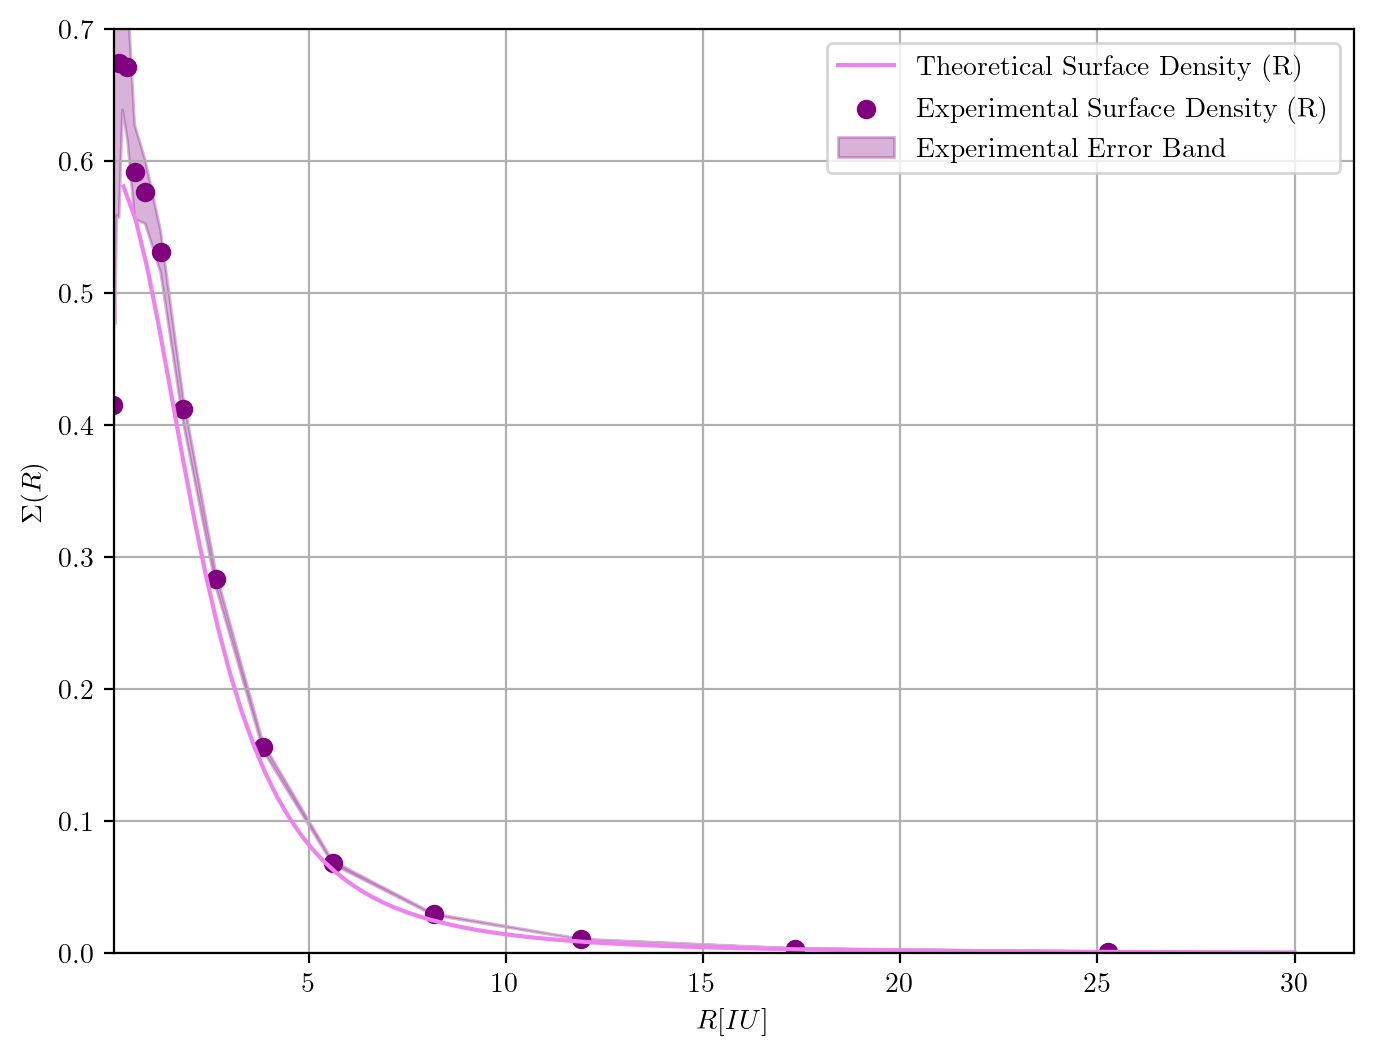

In [51]:


bin_centers_R, surface_density_R_exp,errors  = surface_density_R(m,positions_3d, 20)
# Create the plot
plt.figure(figsize=(8,6))

# Plot the theoretical curve
plt.plot(R_grid, Sigma(R_grid, M_D), label="Theoretical Surface Density (R)", color='violet')

# Plot the experimental points with errors
plt.scatter(bin_centers_R, surface_density_R_exp, 
             label="Experimental Surface Density (R)", 
             color='purple', marker='o')
plt.fill_between(bin_centers_R, 
                 surface_density_R_exp - errors, 
                 surface_density_R_exp + errors, 
                 color='purple', 
                 alpha=0.3,  # Adjust transparency
                 label='Experimental Error Band')
# Calculate the theoretical curve error (if applicable)
# This assumes you might have an error associated with the theoretical model
# If you don't have a specific error calculation, you can use the experimental errors

plt.xlabel('$R [IU]$')
plt.ylabel('$\Sigma (R)$')
plt.grid()
plt.legend(loc='upper right')
plt.xlim(0.05)
plt.ylim(0,0.7)

/tmp/ipykernel_79355/3054370715.py:21: RuntimeWarning: divide by zero encountered in true_divide
  surface_density * np.sqrt(1 / particle_counts),  # Fractional error
/tmp/ipykernel_79355/3054370715.py:21: RuntimeWarning: invalid value encountered in multiply
  surface_density * np.sqrt(1 / particle_counts),  # Fractional error


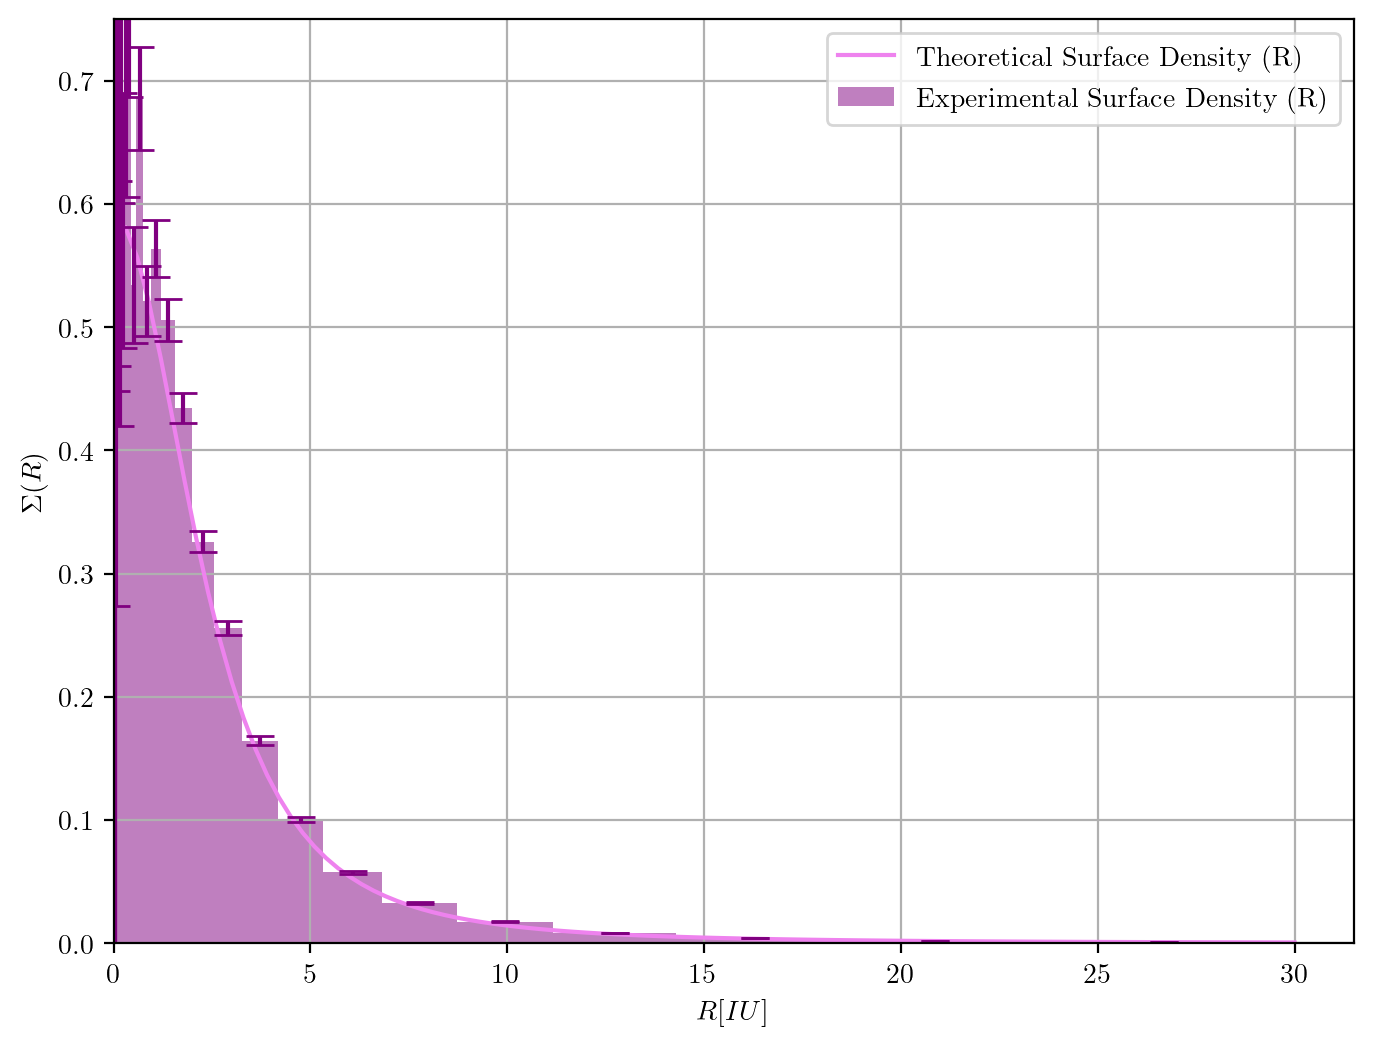

In [56]:

# Ottieni i dati includendo i bin_edges
bin_centers_R, surface_density_R_exp, errors, bin_edges_R = surface_density_R(m, positions_3d, 30)

# Crea il plot
plt.figure(figsize=(8,6))

# Plot la curva teorica
plt.plot(R_grid, Sigma(R_grid, M_D), label="Theoretical Surface Density (R)", color='violet')

# Plot l'istogramma sperimentale
plt.bar(bin_centers_R, 
        surface_density_R_exp,
        width=np.diff(bin_edges_R),  # larghezza delle barre basata sui bin
        alpha=0.5,
        color='purple',
        label="Experimental Surface Density (R)")

# Plot le barre d'errore
plt.errorbar(bin_centers_R, 
            surface_density_R_exp,
            yerr=errors,
            fmt='none',  # nessun marker
            color='purple',
            capsize=5)

plt.xlabel('$R [IU]$')
plt.ylabel('$\Sigma (R)$')
plt.grid()
plt.legend(loc='upper right')
plt.ylim(0,0.75)
plt.xlim(0)
plt.show()

/home/ludovicarbone/astrostat_env/lib/python3.10/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


9.716043780528613


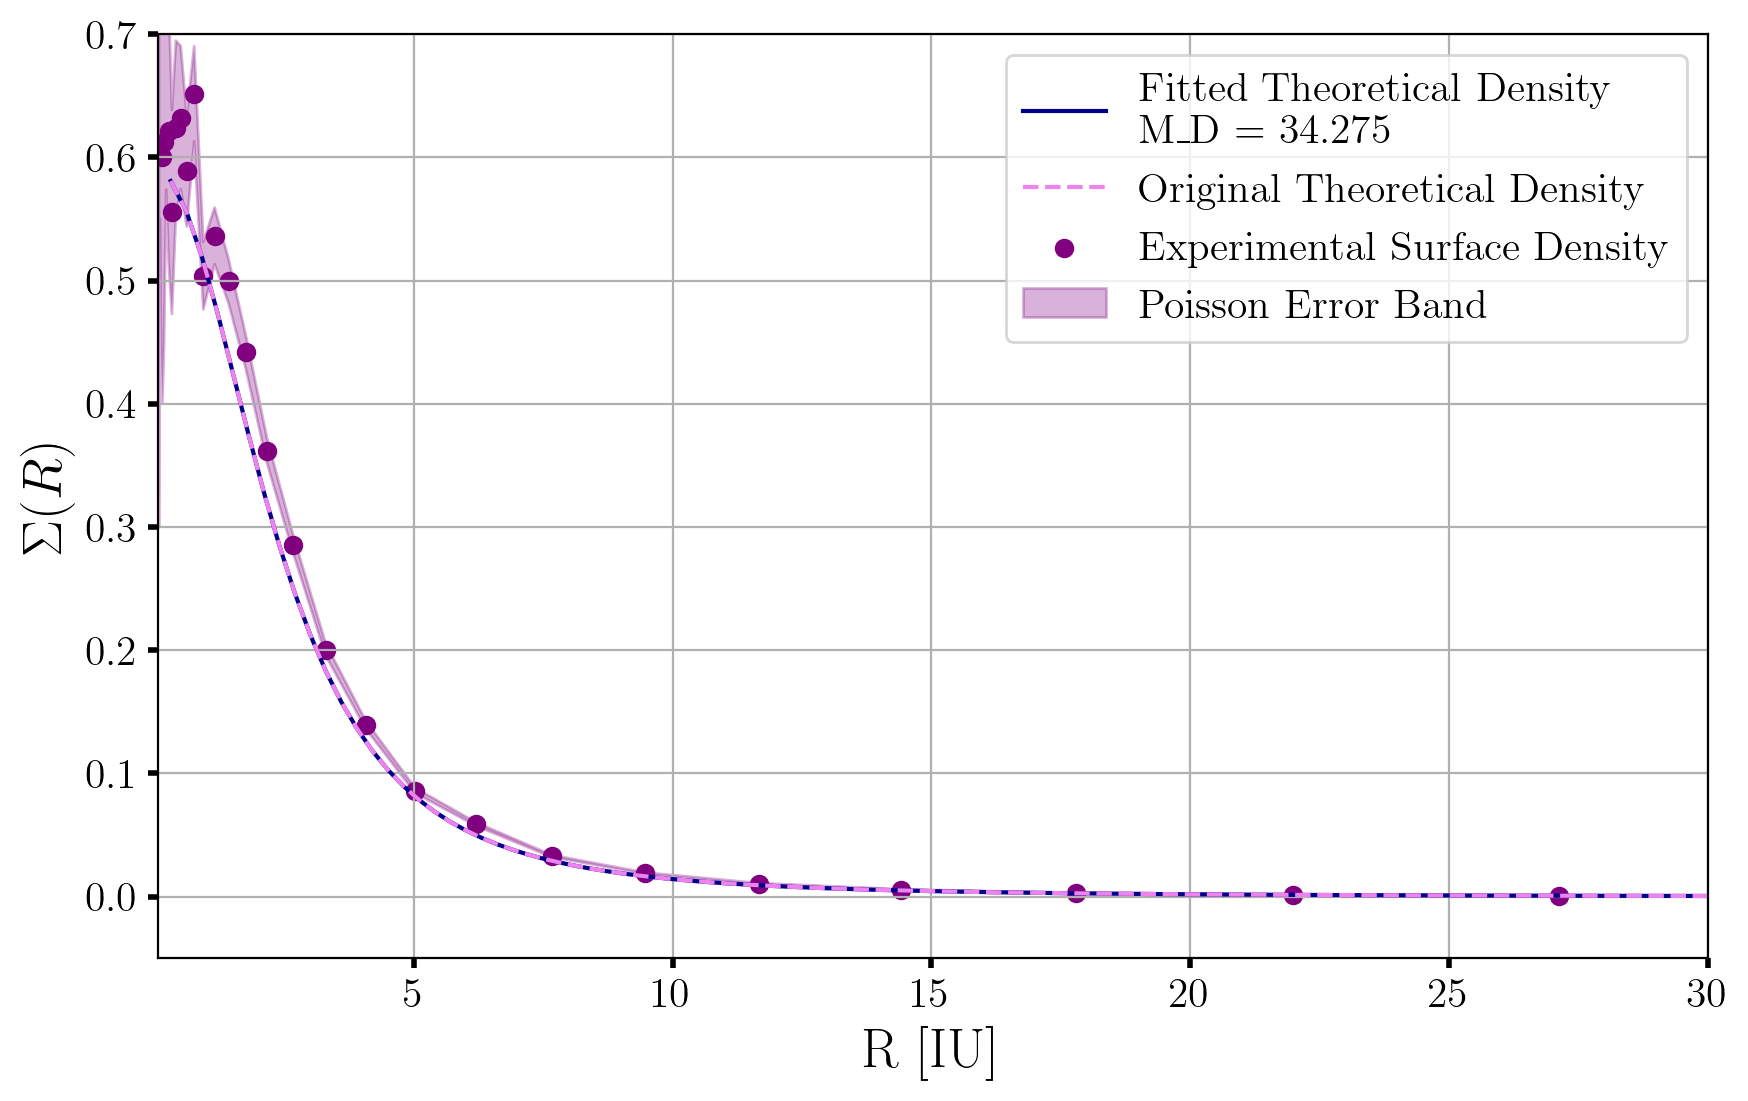

In [23]:
# Filter the particles with R >= 0.05
R_particles = np.sqrt(x_particles**2 + y_particles**2)
mask = R_particles >= 0.05
positions_filtered = positions_3d[mask]
m_filtered = m[mask]

bin_centers_R, surface_density_R_exp, errors = surface_density_R(m_filtered, positions_filtered, 30)
valid_bins = bin_centers_R >= 0.05
bin_centers_R = bin_centers_R[valid_bins]
surface_density_R_exp = surface_density_R_exp[valid_bins]
errors = errors[valid_bins]

#fit
popt, pcov = curve_fit(
    lambda R, M_D_fit: Sigma(R, M_D_fit), 
    bin_centers_R, 
    surface_density_R_exp, 
    sigma=errors, 
    absolute_sigma=True,
    p0=[M_D]
)

#fit par
M_D_fit = popt[0]
M_D_err = np.sqrt(pcov[0, 0])

n = len(bin_centers_R)
n_params = 1
chi2_reduced = np.sum(((surface_density_R_exp - Sigma(bin_centers_R, M_D_fit)) / errors)**2) / (n - n_params)
print(chi2_reduced)

plt.figure(figsize=(10, 6))

plt.plot(R_grid, Sigma(R_grid, M_D_fit), 
         label=f"Fitted Theoretical Density\nM_D = {M_D_fit:.3f}", 
         color='darkblue')

plt.plot(R_grid, Sigma(R_grid, M_D), 
         label="Original Theoretical Density", 
         color='violet', linestyle='--')

plt.scatter(bin_centers_R, surface_density_R_exp, 
            label="Experimental Surface Density", 
            color='purple', marker='o')

plt.fill_between(bin_centers_R, 
                 surface_density_R_exp - errors, 
                 surface_density_R_exp + errors, 
                 color='purple', alpha=0.3, label='Poisson Error Band')

plt.xlabel('R [IU]', fontsize=20)
plt.ylabel('$\Sigma (R)$', fontsize=20)
plt.grid()
plt.legend(loc='upper right', fontsize=15)
plt.xlim(0.05, max(R_grid))
plt.ylim(-0.05, 0.7)
plt.tick_params(axis='both', which='major', labelsize=15, width=2)
plt.savefig('sigma_comparison.png')
plt.show()
